In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math





CONNECTIVITY_MATRIX_SHAPE: (360, 1200)
BRAIN_REGION_INFO: (360, 12)
                          region region_abbrev hemi  region_idx  \
0          Primary Visual Cortex            V1    R           0   
1  Medial Superior Temporal Area           MST    R           1   
2              Sixth Visual Area            V6    R           2   
3             Second Visual Area            V2    R           3   
4              Third Visual Area            V3    R           4   

            network network_abbrev  network_idx  network_region_idx  \
0    Primary Visual           VIS1            1                   4   
1  Secondary Visual           VIS2            2                  97   
2  Secondary Visual           VIS2            2                  98   
3  Secondary Visual           VIS2            2                  99   
4  Secondary Visual           VIS2            2                 100   

  network_colour      mni_x      mni_y      mni_z  
0      royalblue -12.684422 -82.321608   1.542622 

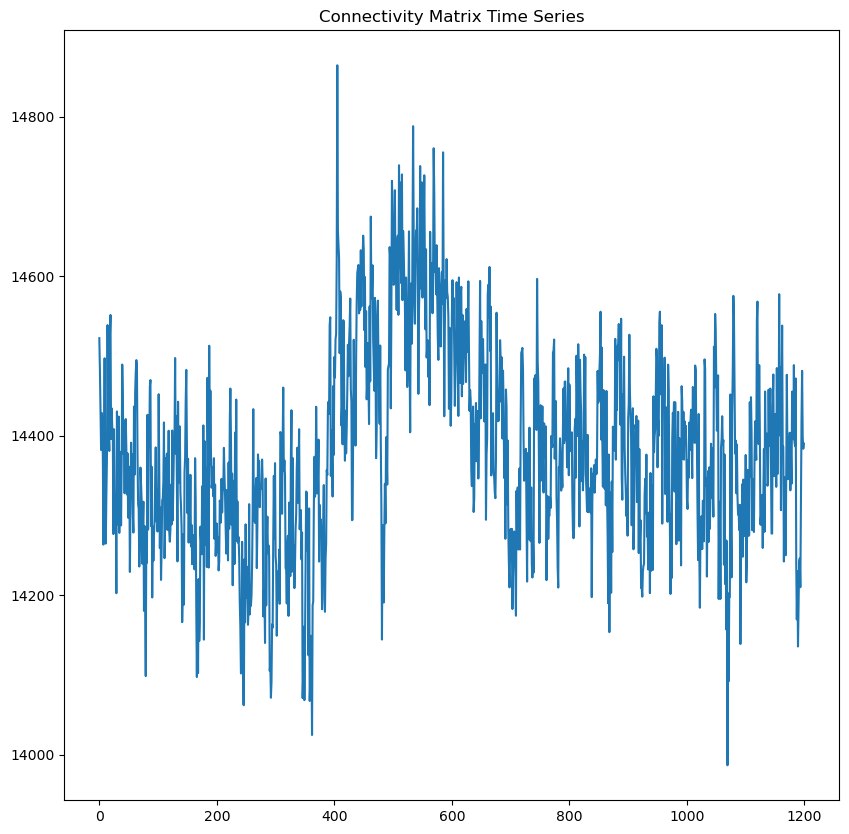

In [2]:
path_conn = '../data/hcp/raw/100206_0.npy'
path_brain_region = '../data/brain_regions.csv'

# Load the connectivity matrix
connectivity_matrix = np.load(path_conn)

# Load the brain regions
brain_regions = pd.read_csv(path_brain_region)

# Check the shape of your connectivity matrix
print("CONNECTIVITY_MATRIX_SHAPE:", connectivity_matrix.shape)
print("BRAIN_REGION_INFO:", brain_regions.shape)

# Check the first few rows of your brain regions data
print(brain_regions.head())

# Basic visualization of the connectivity matrix
# plt.figure(figsize=(10, 10))
# sns.heatmap(connectivity_matrix, cmap='viridis')
# plt.title('Connectivity Matrix')
# plt.show()

plt.figure(figsize=(10, 10))
plt.plot(connectivity_matrix[359])
plt.title('Connectivity Matrix Time Series')
plt.show()



SCAN_SHAPE:  (360, 490)
FC_MATRIX_SHAPE: (16, 360, 360)


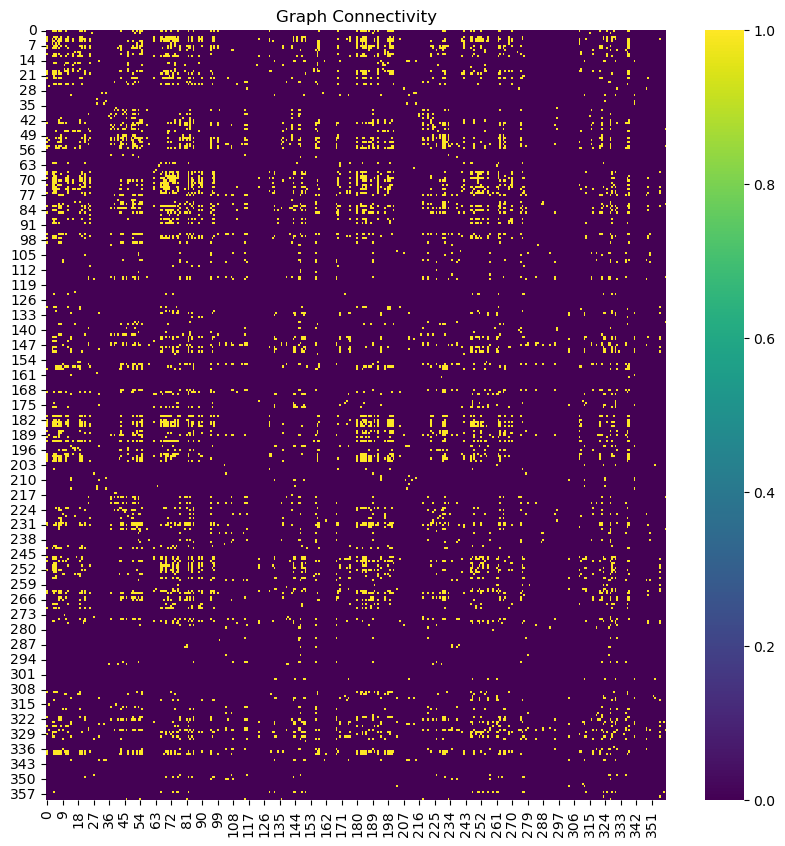

In [3]:
scan = np.load(path_conn)[:, :490]
print('SCAN_SHAPE: ', scan.shape)

def create_fc_matrices(scan, window_size=30, step_size=30):
    """
    Create functional connectivity matrices using a sliding window approach.
    """
    n_timepoints = scan.shape[1]
    fc_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window = scan[:, start:start + window_size]
        correlation_matrix = np.corrcoef(window)
        fc_matrices.append(correlation_matrix)

    return fc_matrices

# Example of processing one scan
fc_matrices = create_fc_matrices(scan)
print('FC_MATRIX_SHAPE:', np.array(fc_matrices).shape)

def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph

# Example of thresholding one FC matrix
graphs = [threshold_fc_matrix(fc) for fc in fc_matrices]     # --> ho 16 grafi, per ogni time_window (30)

# Heatmap of one graph of 16
plt.figure(figsize=(10, 10))
sns.heatmap(graphs[0], cmap='viridis')
plt.title('Graph Connectivity')
plt.show()

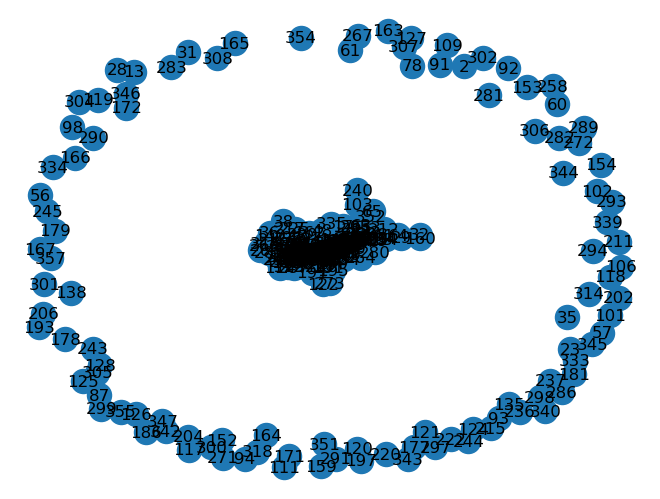

GRAPHS_SHAPE: (16, 360, 360)


In [4]:
import networkx as nx

def create_networkx_graph(matrix):
    G = nx.Graph(matrix)
    return G

# Visualize one graph using NetworkX
G = create_networkx_graph(graphs[0])
nx.draw(G, with_labels=True)
plt.show()
print("GRAPHS_SHAPE:" ,np.array(graphs).shape)

In [5]:
from torch_geometric.data import Data

def convert_to_pyg_graph(nx_graph):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    
    # For unsupervised learning, you typically don't have node labels
    # If you have node features, replace x with them
    return Data(x=x, edge_index=edges)

In [6]:
pyg_graphs = [convert_to_pyg_graph(g) for g in graphs]

for i in range(len(pyg_graphs)):
    print(pyg_graphs[i])

# --> every region can be connected to the 5% of nodes, (((N-1) * N)/2) * 5/100

Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])


### DBGDGM Model (Simeon paper)

In [7]:
num_samples = 1
embedding_dim = 128
num_nodes = 360
categorical_dim = 3

list_graph = []
for i in range(len(graphs)):
    graph = nx.Graph(graphs[i])
    list_graph.append(graph)


In [8]:
def divide_graph_snapshots(time_len, valid_prop, test_prop):
    """
    Divides graph snapshots into training, validation, and testing sets based on the provided proportions.

    Args:
        time_len (int): Total number of graph snapshots.
        valid_prop (float): Proportion of the graph snapshots to use for validation.
        test_prop (float): Proportion of the graph snapshots to use for testing.

    Returns:
        tuple: The number of graph snapshots for training, validation, and testing sets.

    Raises:
        ValueError: If `valid_prop` and `test_prop` don't add up to less than 1.
        ValueError: If `valid_time`, `test_time`, or `train_time` is not greater than 0.
    """

    if valid_prop + test_prop >= 1:
        raise ValueError("Sum of `valid_prop` and `test_prop` must be less than 1.")

    valid_time = math.floor(time_len * valid_prop)
    test_time = math.floor(time_len * test_prop)
    train_time = time_len - valid_time - test_time

    if valid_time <= 0 or test_time <= 0 or train_time <= 0:
        raise ValueError("The calculated `train_time`, `valid_time`, or `test_time` is not greater than 0. "
                         "You might have to adjust your window size or stride.")

    return train_time, valid_time, test_time


def kld_gauss(mu_1: torch.Tensor, std_1: torch.Tensor, mu_2: torch.Tensor, std_2_scale: float) -> torch.Tensor:
    """
    Computes the Kullback-Leibler Divergence (KLD) between two Gaussian distributions.

    Args:
        mu_1 (Tensor): Mean of the first Gaussian distribution.
        std_1 (Tensor): Standard deviation of the first Gaussian distribution.
        mu_2 (Tensor): Mean of the second Gaussian distribution.
        std_2_scale (float): Standard deviation scale of the second Gaussian distribution.

    Returns:
        Tensor: The KLD between the two Gaussian distributions.
    """
    std_2 = torch.ones_like(std_1).mul(std_2_scale).to(mu_1.device)
    KLD = 0.5 * torch.sum(
        (2 * torch.log(std_2 + 1e-20) - 2 * torch.log(std_1 + 1e-20) +
         (std_1.pow(2) + (mu_1 - mu_2).pow(2)) / std_2.pow(2) - 1))
    return KLD


def reparameterized_sample(mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """
    Samples from a Gaussian distribution using the reparameterization trick.

    Args:
        mean (Tensor): The mean values of the Gaussian distribution.
        std (Tensor): The standard deviations of the Gaussian distribution.

    Returns:
        Tensor: A tensor sampled from the Gaussian distribution defined by the mean and standard deviation.
    """
    eps = torch.randn_like(std).to(mean.device)
    return eps.mul(std).add_(mean)


def bce_loss(p_c_given_z: torch.Tensor, c: torch.Tensor, reduction: str = 'sum') -> torch.Tensor:
    """
    Computes the Binary Cross-Entropy (BCE) loss.

    Args:
        p_c_given_z (Tensor): Predicted probabilities.
        c (Tensor): Ground truth values.
        reduction (str, optional): Specifies the reduction to apply to the output. Default is 'sum'.

    Returns:
        Tensor: The BCE loss.
    """
    recon_c_softmax = F.log_softmax(p_c_given_z, dim=-1)
    bce = F.nll_loss(recon_c_softmax, c, reduction=reduction)
    return bce


def kld_z_loss(q: torch.Tensor, p_prior: torch.Tensor) -> torch.Tensor:
    """
    Computes the Kullback-Leibler Divergence (KLD) loss.

    Args:
        q (Tensor): The approximate posterior probability distribution.
        p_prior (Tensor): The prior probability distribution.

    Returns:
        Tensor: The KLD loss.
    """
    log_q = torch.log(q + 1e-20)
    kld = (torch.sum(q * (log_q - torch.log(p_prior + 1e-20)), dim=-1)).sum()
    return kld

In [9]:
alpha_mean = nn.Embedding(num_samples, embedding_dim)
alpha_std = nn.Embedding(num_samples, embedding_dim)
alpha_mean_prior = torch.zeros(embedding_dim)
alpha_std_scalar = 1.
subject_to_phi = nn.Linear(embedding_dim, num_nodes * embedding_dim)
subject_to_beta = nn.Linear(embedding_dim, categorical_dim * embedding_dim)
rnn_nodes = nn.GRU(2 * embedding_dim, embedding_dim, num_layers=1, bias=True)
rnn_comms = nn.GRU(2 * embedding_dim, embedding_dim, num_layers=1, bias=True)
beta_mean = nn.Linear(embedding_dim, embedding_dim)
beta_std = nn.Sequential(nn.Linear(embedding_dim, embedding_dim), nn.Softplus())
phi_mean = nn.Linear(embedding_dim, embedding_dim)
phi_std = nn.Sequential(nn.Linear(embedding_dim, embedding_dim), nn.Softplus())
nn_pi = nn.Linear(embedding_dim, categorical_dim, bias=False)
decoder = nn.Sequential(nn.Linear(embedding_dim, num_nodes, bias=False))

alpha_mean_n = alpha_mean.weight[0]
alpha_std_n = F.softplus(alpha_std.weight[0])
alpha_n = alpha_mean_n 
print("alpha_n: ", alpha_n.shape)
phi_0_mean = subject_to_phi(alpha_n).view(num_nodes, embedding_dim)
print("phi_0_mean: ", phi_0_mean.shape)
beta_0_mean = subject_to_beta(alpha_n).view(categorical_dim, embedding_dim)
print("beta_0_mean: ", beta_0_mean.shape)
kld_alpha = kld_gauss(alpha_mean_n, alpha_std_n, alpha_mean_prior, alpha_std_scalar)

LOSS_KEYS = ['nll', 'kld_z', 'kld_alpha', 'kld_beta', 'kld_phi']
loss = {key: 0 for key in LOSS_KEYS}
edge_counter = 0
train_time, valid_time, test_time = divide_graph_snapshots(len(list_graph), 0.1, 0.1)

h_beta = torch.zeros(1, categorical_dim, embedding_dim)
h_phi = torch.zeros(1, num_nodes, embedding_dim)

for snapshot_idx in range(0, train_time):
    graph = list_graph[snapshot_idx]
    train_edges = [(u, v) for u, v in graph.edges()]
    # np.random.shuffle(train_edges)   --> è necessario?

    batch = torch.LongTensor(train_edges)
    assert batch.shape == (len(train_edges), 2)
    w = torch.cat((batch[:, 0], batch[:, 1]))
    c = torch.cat((batch[:, 1], batch[:, 0]))

    # h_phi, h_beta = self._update_hidden_states(phi_prior_mean, beta_prior_mean, h_phi, h_beta)
    nodes_in = torch.cat([phi_0_mean, phi_0_mean], dim=-1).view(1, num_nodes,
                                                                            2 * embedding_dim)
    _, h_phi = rnn_nodes(nodes_in, h_phi)
    comms_in = torch.cat([beta_0_mean, beta_0_mean], dim=-1).view(1, categorical_dim,
                                                                              2 * embedding_dim)
    _, h_beta = rnn_comms(comms_in, h_beta)

    # (beta_sample, beta_mean_t, beta_std_t), (phi_sample, phi_mean_t, phi_std_t) = self._sample_embeddings(h_phi, h_beta)
    beta_mean_t = beta_mean(h_beta[-1])
    beta_std_t = beta_std(h_beta[-1])
    phi_mean_t = phi_mean(h_phi[-1])
    phi_std_t = phi_std(h_phi[-1])
    beta_sample = reparameterized_sample(beta_mean_t, beta_std_t)
    phi_sample = reparameterized_sample(phi_mean_t, phi_std_t)

    # recon, posterior_z, prior_z = self._edge_reconstruction(w, c, phi_sample, beta_sample, temp)
    q = nn_pi(phi_sample[w] * phi_sample[c])  # q(z|w, c)
    p_prior = nn_pi(phi_sample[w])  # p(z|w)
    
    # z = gumbel_softmax(q, self.device, tau=temp, hard=True)
    z = F.softmax(q, dim=-1)
    beta_mixture = torch.mm(z, beta_sample)  # Community mixture embeddings
    p_c_given_z = decoder(beta_mixture)  # p(c|z)

    beta_prior_mean = beta_sample
    phi_prior_mean = phi_sample

    loss['nll'] += bce_loss(p_c_given_z, c)
    loss['kld_z'] += kld_z_loss(F.softmax(q, dim=-1), F.softmax(p_prior, dim=-1))
    loss['kld_alpha'] += kld_alpha
    loss['kld_beta'] += kld_gauss(beta_sample, beta_std_t, beta_prior_mean, 1.0)
    loss['kld_phi'] += kld_gauss(phi_sample, phi_std_t, phi_prior_mean, 0.1)
    edge_counter += c.shape[0]
    
print("W: ", w.shape)
print("C: ", c.shape)
print("h_phi: ", h_phi.shape)
print("h_beta: ", h_beta.shape)
print("beta_sample: ", beta_sample.shape)
print("phi_sample: ", phi_sample.shape)
print("q(z|w, c): ", q.shape)
print("p(z|w): ", p_prior.shape)
print("p(c|z): ", p_c_given_z.shape)

for loss_name in loss.keys():
    loss[loss_name] = loss[loss_name] / edge_counter
       
        



alpha_n:  torch.Size([128])
phi_0_mean:  torch.Size([360, 128])
beta_0_mean:  torch.Size([3, 128])
W:  torch.Size([6462])
C:  torch.Size([6462])
h_phi:  torch.Size([1, 360, 128])
h_beta:  torch.Size([1, 3, 128])
beta_sample:  torch.Size([3, 128])
phi_sample:  torch.Size([360, 128])
q(z|w, c):  torch.Size([6462, 3])
p(z|w):  torch.Size([6462, 3])
p(c|z):  torch.Size([6462, 360])


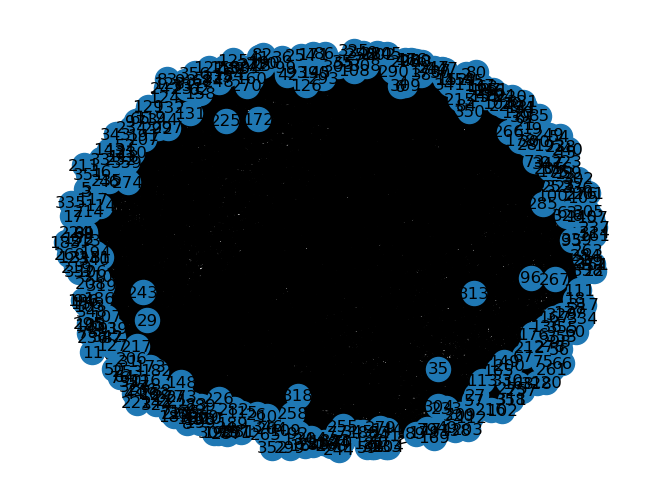

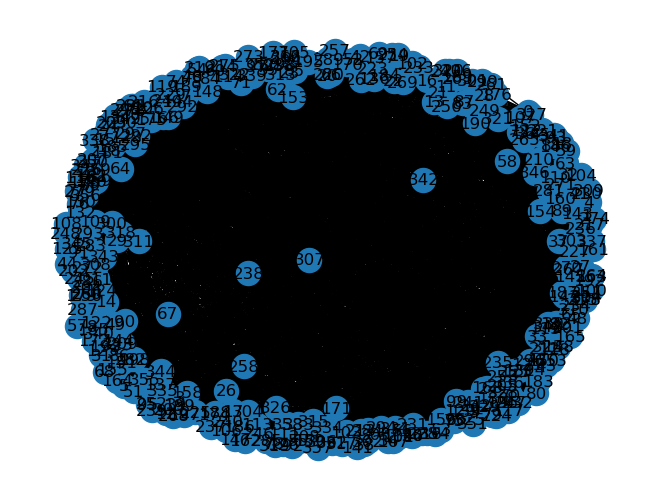

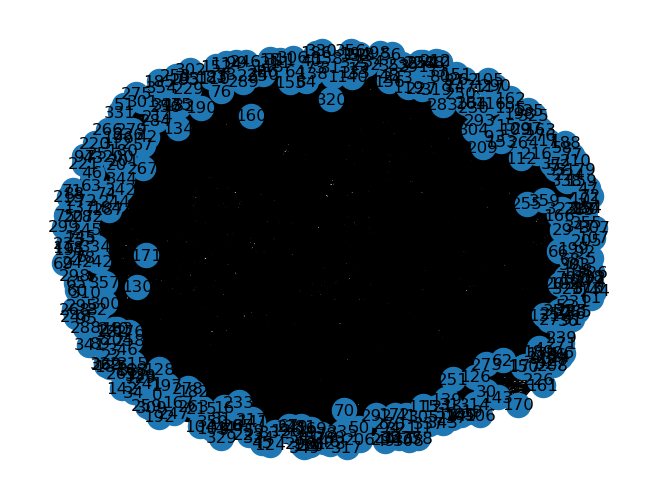

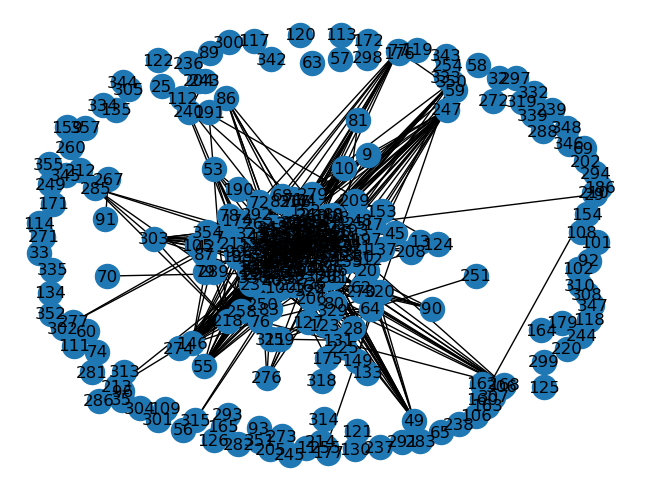

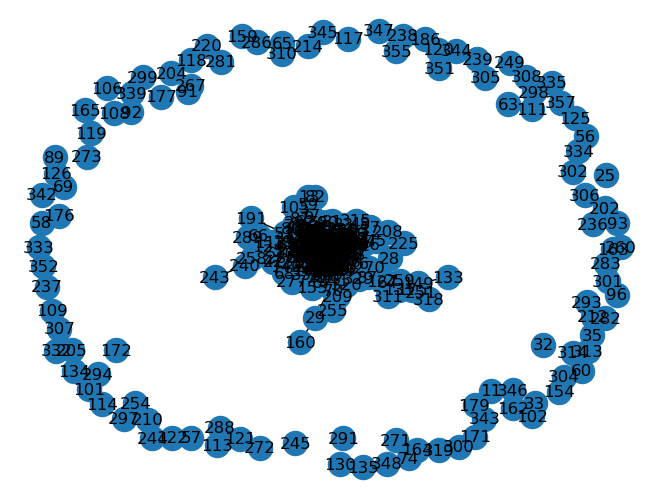

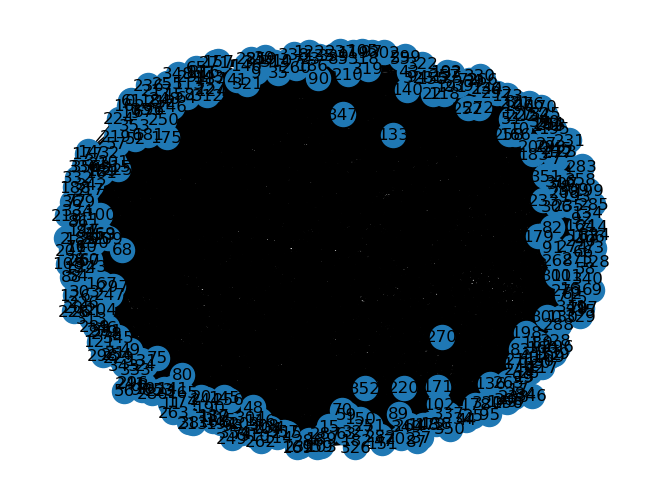

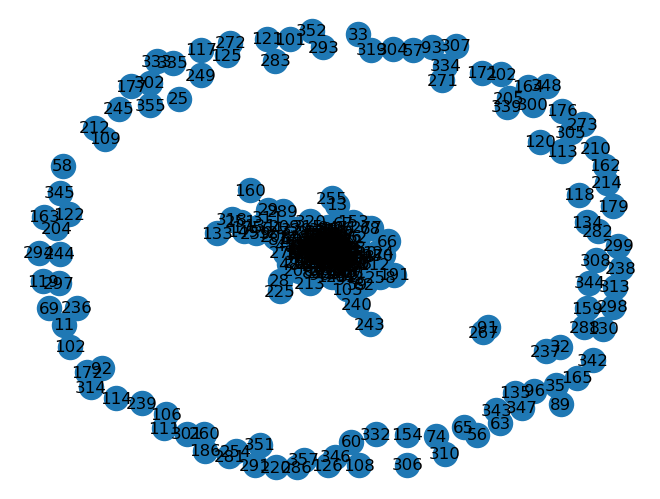

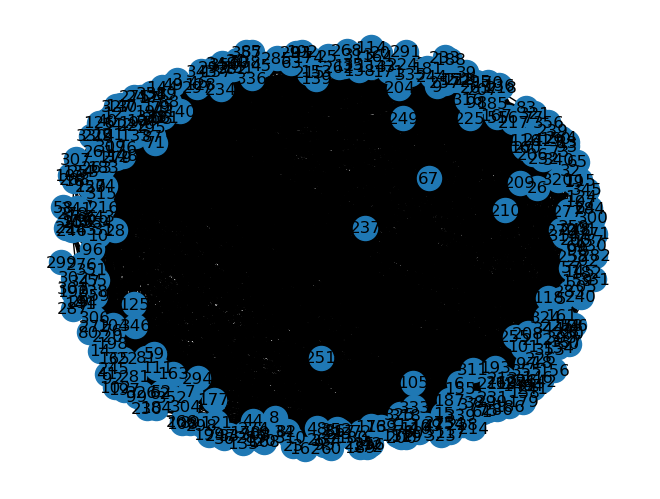

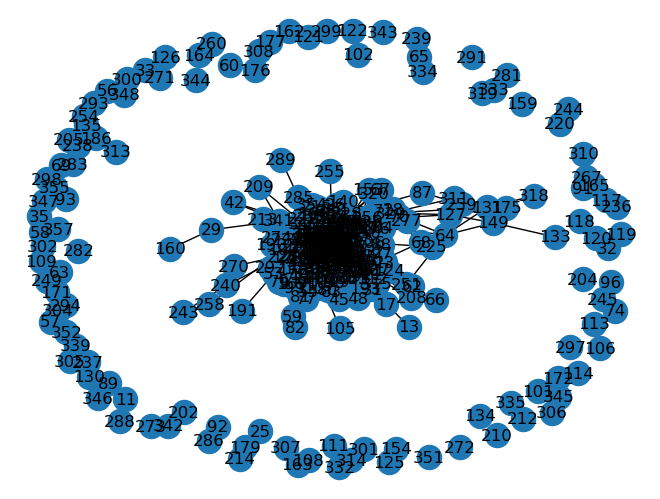

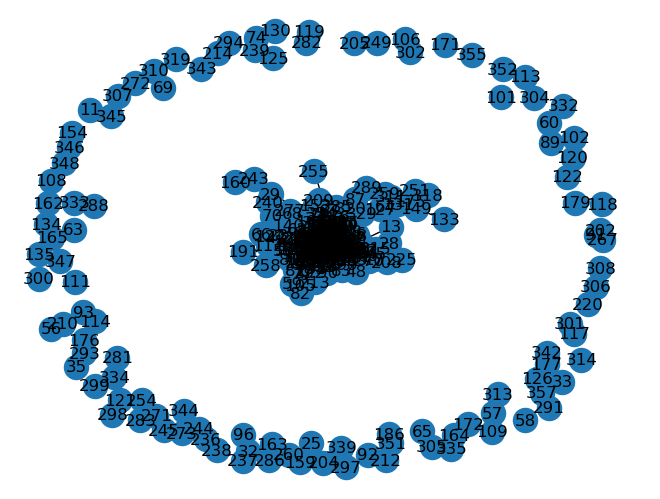

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
# Add nodes with node embeddings from phi_sample
for i in range(num_nodes):
    G.add_node(i, embedding=phi_sample[i].detach().numpy())

# Add edges based on reconstruction probability p_c_given_z --> for every embedding dimension (now first 10)
for j in range(10):
    edges_to_add = [(w[i].item(), c[i].item(), {'weight': p_c_given_z[i][j].tolist()}) for i in range(w.shape[0])]
    G.add_edges_from(edges_to_add)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

### Classification GNN's (Alex paper)

In [4]:
def temporal_splitting_stack(X, P, S):
    """
    Apply temporal-splitting stack transformation to input BOLD signals.
    The purpose of this transformation is to split the original BOLD signal into overlapping windows, each capturing a local temporal pattern.

    Parameters:
    - X: BOLD signals of shape (T', V) where T' is the number of time points and V is the number of brain regions.
    - P: Window length (hyperparameter).
    - S: Stride (hyperparameter).

    Returns:
    - X_tilde: Transformed data of shape (P, V, T) representing the stacked windows.
    """
    T_prime, V = X.shape
    T = int(np.floor((T_prime - 2 * (P - 1) - 1) / S) + 1)
    X_tilde = np.zeros((P, V, T))

    for t in range(T):
        start_idx = t * S
        end_idx = start_idx + P
        X_tilde[:, :, t] = X[start_idx:end_idx, :]

    return X_tilde

X1_T_prime = connectivity_matrix.T
P = 30  # Window length
S = 1  # Stride
X_tilde = temporal_splitting_stack(X1_T_prime, P, S)


In [5]:
print("X_TILDE SHAPE: ", X_tilde.shape)
print("NEW T: ", (X1_T_prime.shape[0]-(2*(P-1))-1)+1)

(30, 360, 1142)
1142


In [6]:
class InceptionTCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels_list, kernel_sizes_list, dilation_factors_list):
        super(InceptionTCNLayer, self).__init__()
        self.branches = nn.ModuleList()

        # Check --> out_channels_list, kernel_sizes_list, and dilation_factors_list are lists
        if not isinstance(out_channels_list, list):
            out_channels_list = [out_channels_list]
        if not isinstance(kernel_sizes_list, list):
            kernel_sizes_list = [kernel_sizes_list]
        if not isinstance(dilation_factors_list, list):
            dilation_factors_list = [dilation_factors_list]
        for i in range(len(out_channels_list)):
            branch = nn.Conv2d(in_channels, out_channels_list[i], kernel_size=(1, kernel_sizes_list[i]), dilation=(1, dilation_factors_list[i]), padding=(0, dilation_factors_list[i]))
            self.branches.append(branch)

    def forward(self, x):
        # Apply each branch and concatenate along the feature dimension
        branch_outputs = [branch(x) for branch in self.branches]
        x = torch.cat(branch_outputs, dim=0)
        return x

class ITCNModel(nn.Module):
    def __init__(self, KE, V, T, num_layers, num_filters_list, kernel_sizes_list, dilation_factors_list):
        super(ITCNModel, self).__init__()
        self.feature_layers = nn.ModuleList()

        for i in range(num_layers):
            in_channels = 1 if i == 0 else num_filters_list[i-1]
            out_channels_list = num_filters_list[i]
            kernel_sizes_list_i = kernel_sizes_list[i]
            dilation_factors_list_i = dilation_factors_list[i]
            layer = InceptionTCNLayer(in_channels, out_channels_list, kernel_sizes_list_i, dilation_factors_list_i)
            self.feature_layers.append(layer)

        # Output layer
        self.output_layer = nn.Conv2d(num_filters_list[-1], KE, kernel_size=(1, 1))

    def forward(self, x):
        for layer in self.feature_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

V, T = 360, 1142 
# Define hyperparameters
KE = 64
num_layers = 3
num_filters_list = [4, 8, 16]  # Number of filters for each layer
kernel_sizes_list = [[3], [5], [7]]  # Kernel sizes for each layer
dilation_factors_list = [[1], [2], [4]]  # d = 2^(l−1)

X_tilde_reshaped = np.array(X_tilde).reshape((30, 1, V, T))   # reshape for first channel = 1
X_tilde_reshaped = torch.Tensor(X_tilde_reshaped)

itcn_model = ITCNModel(KE, V, T, num_layers, num_filters_list, kernel_sizes_list, dilation_factors_list)
itcn_output = itcn_model(X_tilde_reshaped)

print(itcn_output.shape)  


torch.Size([30, 64, 360, 1122])


In [ ]:
# why 1122 =/ 1142 --> depends on dilation_factors --> padding?
# how to handle the window component (30)